In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

## searched sample

In [121]:
key = "iso_lina_m0.70-1.30"
key = "joint_lina_m0.70-1.30"

In [122]:
d = pd.read_csv("../"+key+"/"+key+".csv")

In [123]:
dkic = pd.read_csv("/Users/k_masuda/Dropbox/research_notes/data/kepler_stellar_17.csv", comment='#', delimiter="|")
d = pd.merge(d, dkic[['kepid', 'kepmag']], on='kepid')

In [124]:
from scipy.interpolate import interp1d
dprec = pd.read_csv("../../kepler_prot_teff/data/kepler_precision.txt", delim_whitespace=True)
kepsigma = interp1d(dprec.kepmag, dprec.long, kind='cubic')

In [125]:
params_all = {"robreak": 0.84, "Rbreak": 1.08e4, "bsat": -0.04, "bunsat": -2.61, "lnrsigma": 0.55}
params_mag = {"robreak": 0.99, "Rbreak": 9.7e3, "bsat": -0.02, "bunsat": -4.55, "lnrsigma": 0.59}

In [126]:
tau_g98 = lambda teff: 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002

def rper_ro(ro, p, scatter=False):
    ro = np.atleast_1d(ro)
    ret = (ro/p['robreak'])**p['bsat']
    idx = ro > p['robreak']
    ret[idx] = (ro[idx]/p['robreak'])**p['bunsat']
    if not scatter:
        return ret * p['Rbreak']
    else:
        lnR = np.log(ret * p['Rbreak']) + np.random.randn(len(ret))*p['lnrsigma']
        return np.exp(lnR)

def ro_threshold(mags, params, sigma_th=3.):
    magarr = np.atleast_1d(mags)
    magarr = np.where(magarr < 7, 7, magarr)
    ros = np.linspace(0, 10, 10000)
    rpers = rper_ro(ros, params)
    rper_th = sigma_th * kepsigma(magarr)
    return ros[np.argmin(np.abs(rpers[:,None] - rper_th[None,:]), axis=0)]

In [127]:
mags = np.linspace(5, 18, 1000)
rocut_all = interp1d(mags, ro_threshold(mags, params_all))
rocut_mag = interp1d(mags, ro_threshold(mags, params_mag))

def pdetfunc(ros):
    rocuts = np.array(ros)
    return interp1d(np.r_[-np.inf, np.sort(rocuts), np.inf], np.r_[1, np.cumsum(rocuts)[::-1]/np.cumsum(rocuts)[-1], 0.], kind='linear')

In [128]:
d['rocut_all'] = rocut_all(d.kepmag)
d['rocut_mag'] = rocut_mag(d.kepmag)

In [129]:
pdet_all = pdetfunc(d.rocut_all)
pdet_mag = pdetfunc(d.rocut_mag)

In [130]:
diso = pd.read_csv("../../kepler_prot_teff/data/MIST_1e8yr.txt", comment='#', delim_whitespace=True)
diso['bprp'] = diso['Gaia_BP_DR2Rev'] - diso['Gaia_RP_DR2Rev']
print (diso.keys())

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass',
       'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U',
       'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J',
       '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'Gaia_G_EDR3', 'Gaia_BP_EDR3', 'Gaia_RP_EDR3',
       'phase', 'bprp'],
      dtype='object')


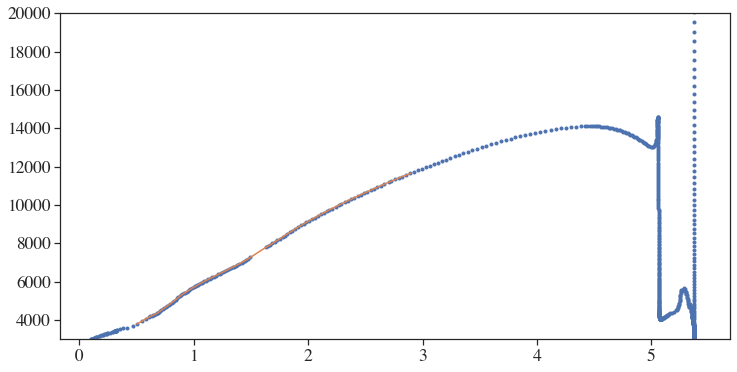

In [131]:
idxm3 = diso.initial_mass < 3
mass2teff = interp1d(diso.initial_mass[idxm3],10**(diso.log_Teff[idxm3]),  kind='cubic')
x = np.linspace(0.5, 2.9, 100)
plt.ylim(3000, 20000)
#plt.xlim(8000, 3000)
plt.plot(diso.initial_mass, 10**diso.log_Teff, '.')
plt.plot(x, mass2teff(x))

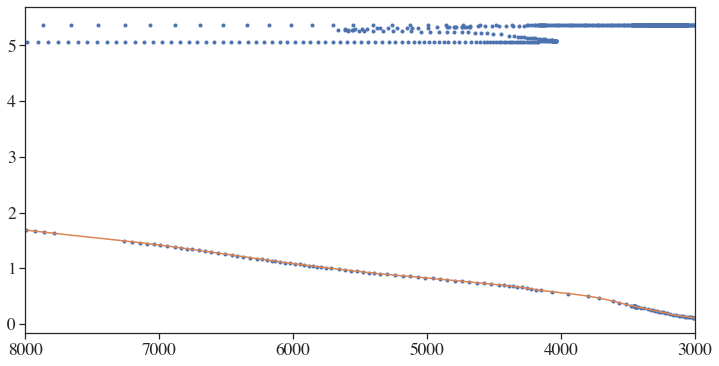

In [132]:
idxm3 = diso.initial_mass < 3
teff2mass = interp1d(10**(diso.log_Teff[idxm3]), diso.initial_mass[idxm3], kind='cubic')
x = np.linspace(3000, 8000, 100)
#plt.ylim(8000, )
plt.xlim(8000, 3000)
plt.plot(10**diso.log_Teff, diso.initial_mass, '.')
plt.plot(x, teff2mass(x))

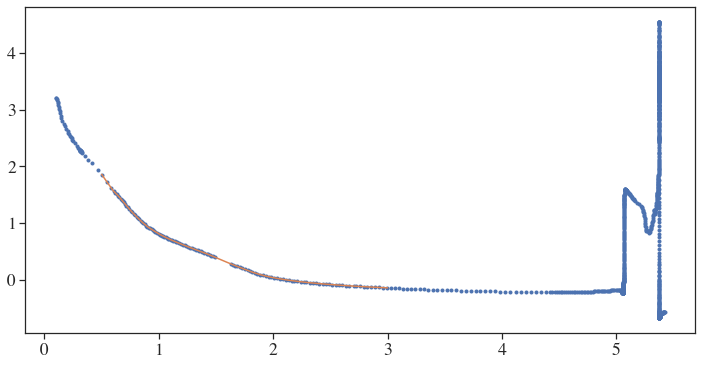

In [133]:
idxm3 = diso.initial_mass < 3.1
mass2bprp = interp1d(diso.initial_mass[idxm3], diso.bprp[idxm3], kind='cubic')
x = np.linspace(0.5, 3)
#plt.ylim(0, 3)
plt.plot(diso.initial_mass, diso.bprp, '.')
plt.plot(x, mass2bprp(x))

In [134]:
resdir = "./"

In [135]:
def convective_overturn_time(mass):
    logm = np.log10(mass)
    logtau = 1.16 - 1.49 * logm - 0.54 * logm * logm
    return 10**logtau

def gyro_model_praesepe(logage, bprp, mass, Ro_cutoff=2):
    # Angus+19 table 1
    # c4, c3, c2, c1, c0, cA, b1, b0
    p = [-38.957586198640314, 28.709418579540294, -4.919056437046026,
         0.7161114835620975, -4.716819674578521, 0.6470950862322454,
         -13.558898318835137, 0.9359250478865809]
    logprot = np.where(bprp < 0.56, 0.56, np.polyval(p[:5], np.log10(bprp)) + p[5]*logage)

    tau = convective_overturn_time(mass)
    logpmax = np.log10(Ro_cutoff * tau)
    Ro = 10**logprot / tau
    logprot = np.where((Ro >= Ro_cutoff) & (bprp >= 0.56), logpmax, logprot)

    return 10**logprot

In [154]:
def tau_g98(teff):
    return 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002
for _m in [0.7, 0.8, 0.9, 1, 1.1, 1.2]:
    _prot = tau_g98(mass2teff(_m))*1
    _loga = np.log10(ages*1e9)
    _prots = gyro_model_praesepe(_loga, mass2bprp(_m), _m, Ro_cutoff=100)
    print (_m, "\t", ages[np.argmin(np.abs(_prots-_prot))])

0.7 	 3.3118118118118125
0.8 	 2.628628628628629
0.9 	 2.0170170170170176
1 	 1.7372372372372378
1.1 	 1.5420420420420424
1.2 	 1.1581581581581584


In [ ]:
gyro_model_praesepe()

In [136]:
def ros_from_ages(ages, mass, Ro_cutoff=2.):
    logage = np.log10(ages*1e9)
    bprp, teff = mass2bprp(mass), mass2teff(mass)
    prot = gyro_model_praesepe(logage, bprp, mass, Ro_cutoff=Ro_cutoff)
    return prot, prot / tau_g98(teff)

age_upper = lambda mass: -30 * (mass-1.25) + 5.

In [137]:
ml, mu = 0.95, 1.05

In [138]:
rc('text', usetex=True*0)

4948.4
5372.7
5704.4
6009.65
6259.5


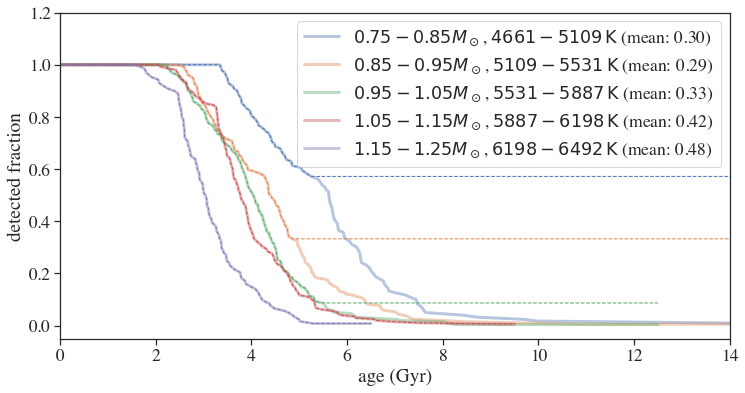

In [139]:
dout = pd.DataFrame(data={})
plt.xlim(0, 14.)
plt.ylim(-0.05, 1.2)
for i,m in enumerate([0.8, 0.9, 1, 1.1, 1.2]):
    ages = np.linspace(0, age_upper(m), 1000)
    prots, ros = ros_from_ages(ages, m, Ro_cutoff=100.)
    prots2, ros2 = ros_from_ages(ages, m, Ro_cutoff=2.)
    
    ml, mu = m-0.05, m+0.05
    tl, tu = mass2teff([ml, mu])
    rocuts = rocut_mag(np.array(d.kepmag[(tl<d.teff)&(d.teff<tu)]))
    rocuts = rocut_mag(np.array(d.kepmag[(ml<d.iso_mass)&(d.iso_mass<mu)]))
    pdet = pdetfunc(rocuts)
    print (np.median(d.teff[(tl<d.teff)&(d.teff<tu)]))

    plt.xlabel("age (Gyr)")
    plt.ylabel("detected fraction")
    #plt.plot(ages, pdet_mag(ros), ls='solid', lw=1.)
    plt.plot(ages, pdet(ros), ls='solid', lw=3, color='C%d'%i, alpha=0.4,
             label='$%.2f-%.2fM_\odot$, $%d-%d\,\mathrm{K}$ (mean: %.2f)'%(ml,mu,tl,tu,np.mean(pdet(ros))))
    plt.plot(ages, pdet(ros2), ls='dashed', lw=1, color='C%d'%i,)
            # label='$%.2f-%.2fM_\odot$, $%d-%d\,\mathrm{K}$ (mean: %.2f)'%(ml,mu,tl,tu,np.mean(pdet(ros))))
        
    dout['m%02d'%(m*10)] = pdet(ros)    
    dout['a%02d'%(m*10)] = ages
plt.legend(loc='best')
plt.savefig(resdir+"joint_pdet_age_mass.png", dpi=200, bbox_inches="tight")

In [141]:
dout.to_csv(key+"_det.csv", index=False)